<a href="https://colab.research.google.com/github/medaminemghirbi/DERMA-TN-backend/blob/master/Deep_Learning_PFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Replace with the dataset you want to download
!kaggle datasets download -d "riyaelizashaju/isic-skin-disease-image-dataset-labelled"

# Unzip the downloaded dataset (if it's a zip file)
!unzip isic-skin-disease-image-dataset-labelled.zip -d isic-skin-disease-image-dataset-labelled

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014157_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014160_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014163_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014171_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014173_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014181_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014183_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC_Labelled/Melanoma/ISIC_0014186_downsampled.jpg  
  inflating: isic-skin-disease-image-dataset-labelled/ISIC

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# General imports
import random
import keras

import shutil

Class counts: [12875, 4522, 867, 253, 3323, 628, 2624, 239]


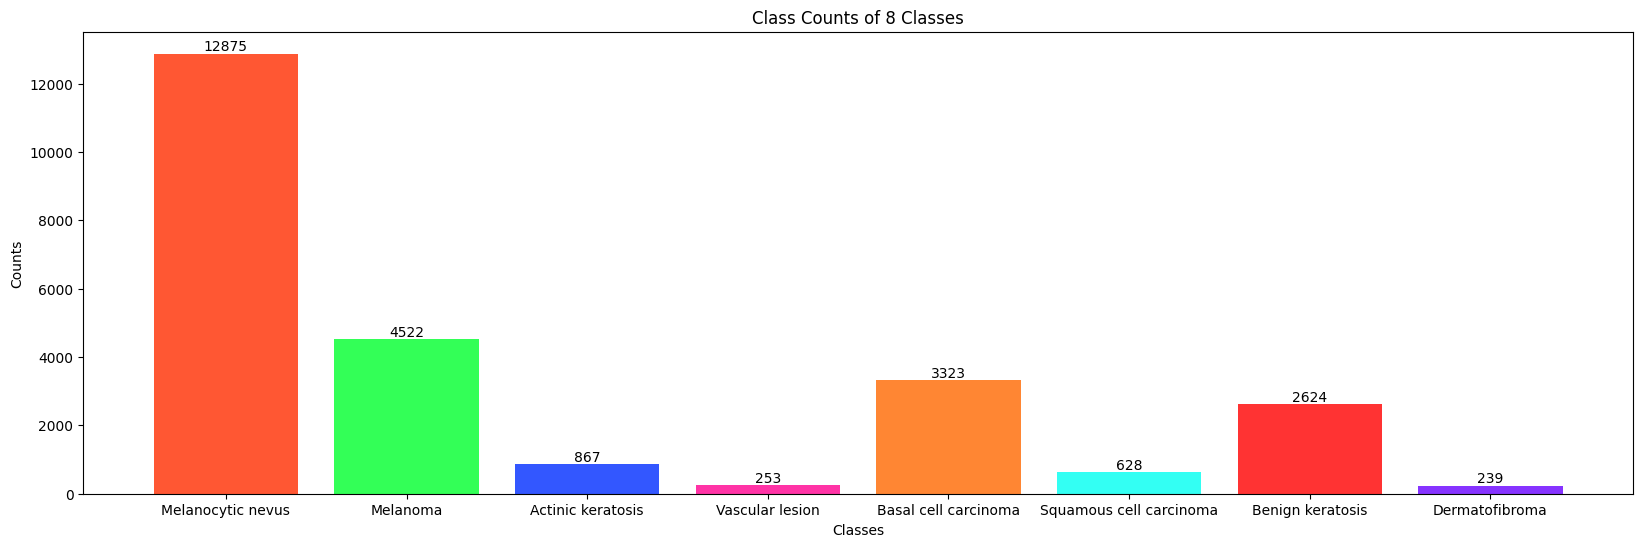

In [3]:
''' Block to visualize class frequencies before oversampling and undersampling '''

# Define paths
data_path = '/content/isic-skin-disease-image-dataset-labelled/ISIC_Labelled'
output_path = '/content/isic-skin-disease-image-dataset-labelled/working/ISIC_Labelled'


# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(data_path, output_path)



# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

In [4]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=4000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target

    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []

        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break

        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=4000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [5]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 4000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Deleted 8875 images for Melanocytic nevus
Deleted 522 images for Melanoma
Processed 4003/4000 images for Actinic keratosis
Processed 4029/4000 images for Vascular lesion
Processed 4027/4000 images for Basal cell carcinoma
Processed 4020/4000 images for Squamous cell carcinoma
Processed 4000/4000 images for Benign keratosis
Processed 4015/4000 images for Dermatofibroma
Oversampling and undersampling completed successfully.


Class counts: [4000, 4000, 3989, 4010, 4026, 4008, 3999, 3992]


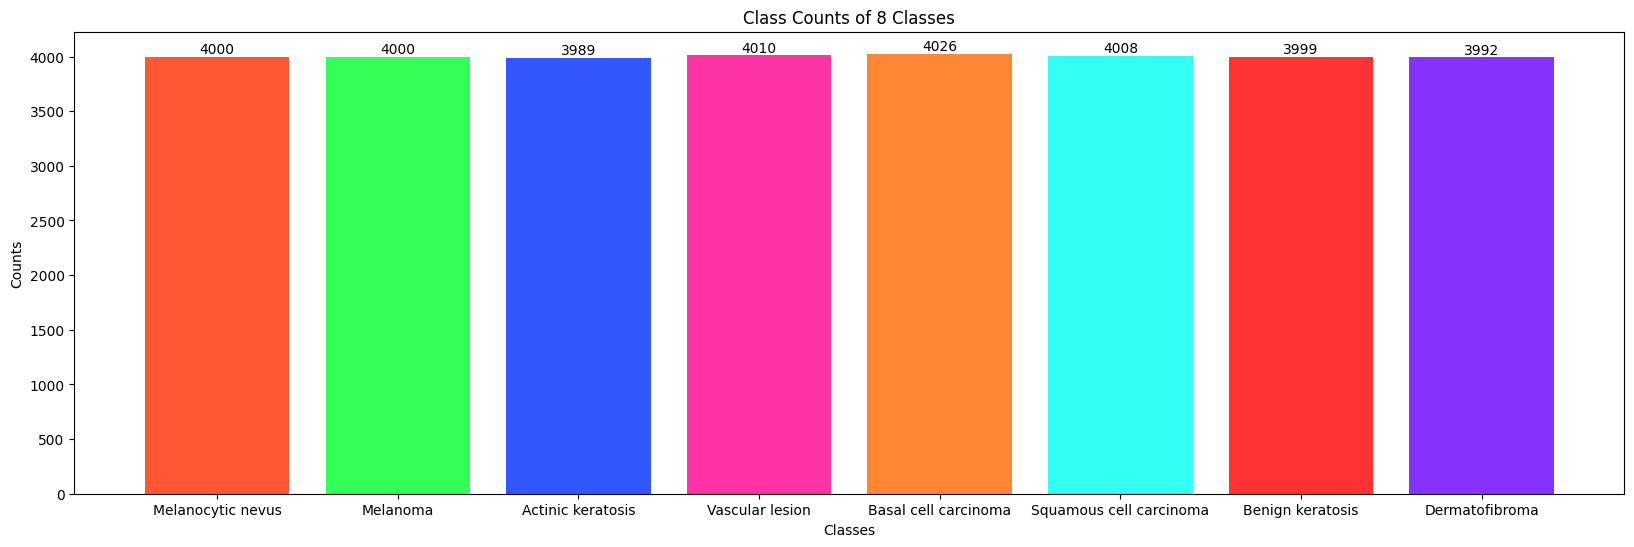

In [6]:
# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

In [7]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/content/isic-skin-disease-image-dataset-labelled/working/train'
val_path = '/content/isic-skin-disease-image-dataset-labelled/working/val'
test_path = '/content/isic-skin-disease-image-dataset-labelled/working/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(output_path):  # using the output_path where dataset resides
    class_path = os.path.join(output_path, class_folder)

    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)

    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


In [9]:
import os

# Paths to the ZIP files
zip_files = [
    '/content/isic-skin-disease-image-dataset-labelled/working/test/train_split.zip',
    '/content/isic-skin-disease-image-dataset-labelled/working/test/val_split.zip',
    '/content/isic-skin-disease-image-dataset-labelled/working/test/test_split.zip'
]

# Loop through and remove each ZIP file
for zip_file in zip_files:
    if os.path.exists(zip_file):
        os.remove(zip_file)
        print(f"Deleted: {zip_file}")
    else:
        print(f"File not found: {zip_file}")

File not found: /content/isic-skin-disease-image-dataset-labelled/working/test/train_split.zip
File not found: /content/isic-skin-disease-image-dataset-labelled/working/test/val_split.zip
File not found: /content/isic-skin-disease-image-dataset-labelled/working/test/test_split.zip


In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/content/isic-skin-disease-image-dataset-labelled/working/train'
val_path = '/content/isic-skin-disease-image-dataset-labelled/working/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

# Display class names (optional)
print("Class Names:", class_names)

Found 22415 files belonging to 8 classes.
Found 4800 files belonging to 8 classes.
Class Names: ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


(32, 256, 256, 3)
[4 2 0 1 1 2 5 5 7 0 0 1 5 4 4 5 7 3 5 4 3 6 5 5 0 1 6 4 7 5 3 4]


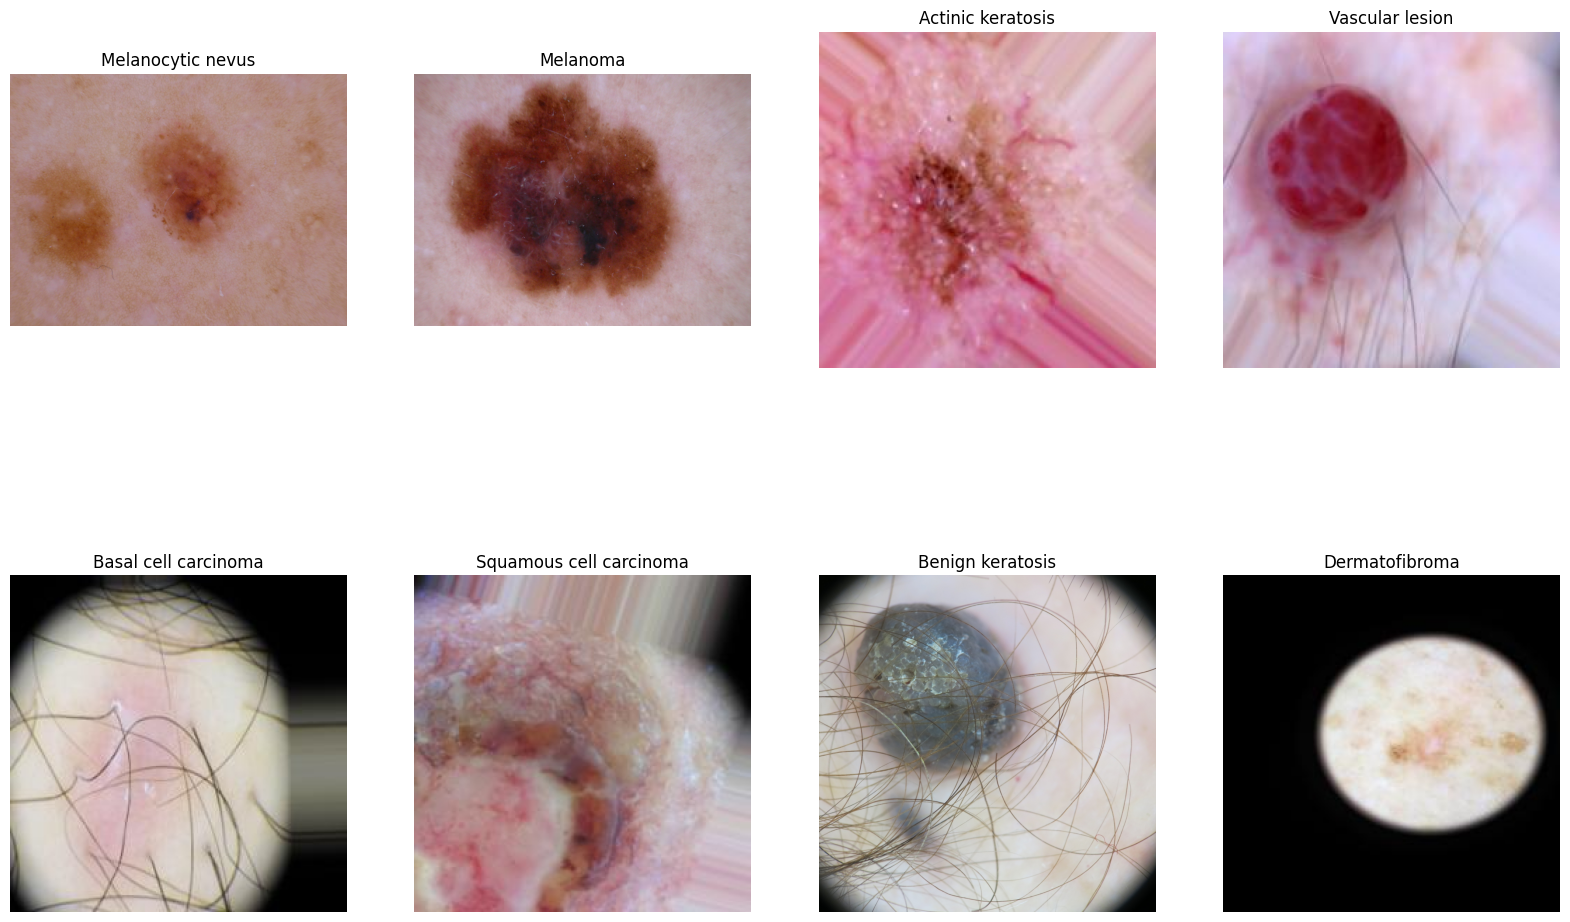

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Displaying a batch of images and labels from the train dataset
for image_batch, labels_batch in train_dataset.take(1):  # Take the first batch from the train dataset
    print(image_batch.shape)  # Print the shape of the image batch (should be [batch_size, img_size[0], img_size[1], 3])
    print(labels_batch.numpy())  # Print the corresponding labels of the images

# Visualizing images from the first few classes in the training dataset
plt.figure(figsize=(20, 20))
i = 0
for image_class in os.listdir(train_path):
    class_path = os.path.join(train_path, image_class)
    image_file = os.listdir(class_path)[0]  # Get the first image from each class
    image_path = os.path.join(class_path, image_file)
    image = Image.open(image_path)

    # Display the image in a grid
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(image_class)
    plt.axis("off")  # Hide axes for a cleaner image display
    i += 1

plt.show()

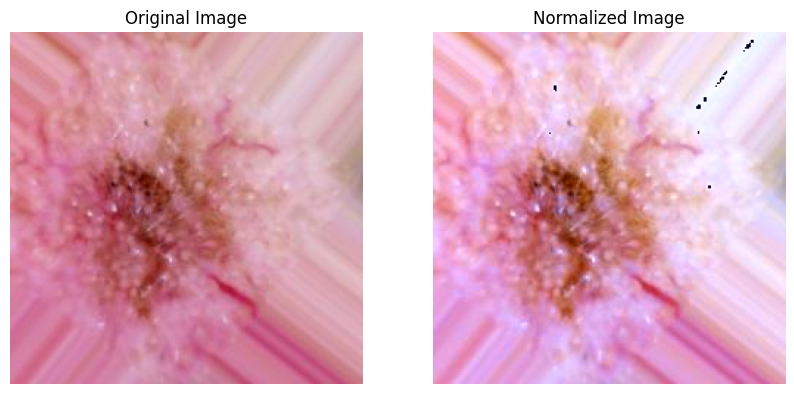

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def stain_normalization(image, target_mean=np.array([196, 154, 122]), target_std=np.array([33, 11, 13])):
    # Convert image to LAB color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Compute mean and standard deviation of each channel
    image_mean = np.mean(image_lab, axis=(0, 1))
    image_std = np.std(image_lab, axis=(0, 1))

    # Perform stain normalization
    image_lab[:, :, 0] = (image_lab[:, :, 0] - image_mean[0]) * (target_std[0] / image_std[0]) + target_mean[0]
    image_lab[:, :, 1] = (image_lab[:, :, 1] - image_mean[1]) * (target_std[1] / image_std[1]) + target_mean[1]
    image_lab[:, :, 2] = (image_lab[:, :, 2] - image_mean[2]) * (target_std[2] / image_std[2]) + target_mean[2]

    # Convert back to RGB color space
    normalized_image = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)

    return normalized_image

# Example usage - Adjusting the path to load an image from the train dataset directory
train_path = '/content/isic-skin-disease-image-dataset-labelled/working/train'
class_name = 'Actinic keratosis'  # Use any class from your dataset
class_path = os.path.join(train_path, class_name)

# Load the first image from the selected class
image_file = os.listdir(class_path)[0]
image_path = os.path.join(class_path, image_file)
input_image = plt.imread(image_path)

# Apply stain normalization
normalized_image = stain_normalization(input_image)

# Display original and normalized images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Image')
plt.axis('off')

# Normalized Image
plt.subplot(1, 2, 2)
plt.imshow(normalized_image)
plt.title('Normalized Image')
plt.axis('off')

plt.show()


In [14]:
# Preprocessing function
import tensorflow as tf
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

In [15]:
from keras.applications.efficientnet import preprocess_input


# Feature extractor
base_model = keras.applications.EfficientNetB3(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(8, activation='softmax')(x) #output layer
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/50
  3/701 [..............................] - ETA: 1:41:17 - loss: 2.1490 - accuracy: 0.1250